## Finally We get to the third model
SPOILER: I received result I wanted

Let's import os library

In [82]:
import os

You can upload your `kaggle.json` file

In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maryanpetlyovanyy","key":"d1656d34430a1dedc3c4b95bd129d671"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d khlaifiabilel/military-aircraft-recognition-dataset -p /content/


 99% 1.11G/1.13G [00:13<00:00, 72.2MB/s]
100% 1.13G/1.13G [00:13<00:00, 86.3MB/s]


In [20]:
!unzip /content/military-aircraft-recognition-dataset.zip -d /content/military-aircraft-recognition-dataset/


Streaming output truncated to the last 5000 lines.
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3416.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3417.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3418.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3419.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/342.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3420.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3421.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/3422.xml  
  inflating: /content/military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxe

You can import yaml config file or leave default configuration

In [21]:
files.upload()

{}

In [23]:
import yaml


config = None
try:
  with open('model2.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
except:
    print("No yaml config found")
if config:
  INPUT_SIZE = config['INPUT_SIZE']
  N_SAMPLES = config['N_SAMPLES']
  LR = float(config['LR'])
  BATCH_SIZE = config['BATCH_SIZE']
  EPOCHS = config['EPOCHS']
else:
  INPUT_SIZE = (224,224)
  N_SAMPLES = 1000
  LR = 1e-3
  BATCH_SIZE = 32
  EPOCHS = 50

No yaml config found


## Additional constansts paths fro google colab and selective search parameters


In [24]:
ORIG_BASE_PATH = "/content/military-aircraft-recognition-dataset"
ORIG_IMAGES = "/content/military-aircraft-recognition-dataset/JPEGImages"
ORIG_ANNOTS = "/content/military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes"

BASE_PATH = "/content/new_data"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "aircraft"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_aircraft"])

MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

MAX_POSITIVE = 30
MAX_NEGATIVE = 10

MODEL_PATH = "aircraft_detector.h5"
ENCODER_PATH = "label_encoder.pickle"


MIN_PROBA = 0.01

## Let's define Intersection over Union and Non-Max Suppression functions

In [118]:
def compute_iou(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)

	return iou

In [26]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	if len(boxes) == 0:
		return []

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	pick = []

	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	if probs is not None:
		idxs = probs

	idxs = np.argsort(idxs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		overlap = (w * h) / area[idxs[:last]]

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	return pick

## Next cells create directories based on the labels to distribute them

In [27]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

for dirPath in (POSITVE_PATH, NEGATIVE_PATH):
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)

In [28]:
imagePaths = list(paths.list_images(ORIG_IMAGES))

In [29]:
totalPositive = 0
totalNegative = 0

In [30]:
labels = set()
for (i, imagePath) in enumerate(imagePaths):
  filename = imagePath.split(os.path.sep)[-1]
  filename = filename[:filename.rfind(".")]
  annotPath = os.path.sep.join([ORIG_ANNOTS,"{}.xml".format(filename)])
  contents = open(annotPath).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []
  label = soup.find("name").string
  labels.add(label)

In [31]:
dir_paths = set()

In [32]:
for dirPath in labels:
  if not os.path.exists(os.path.join(BASE_PATH, dirPath)):
   os.makedirs(os.path.join(BASE_PATH, dirPath))
  dir_paths.add(os.path.join(BASE_PATH, dirPath))

## Next cell do Selective Search using OpenCV to distribute images into (aircraft_label)/no_aircraft

In [ ]:
N = 200 # about samples from each class

class_image_counts = {}


for (i, imagePath) in enumerate(imagePaths):
  print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths)))
  print(class_image_counts)

  filename = imagePath.split(os.path.sep)[-1]
  filename = filename[:filename.rfind(".")]
  annotPath = os.path.sep.join([ORIG_ANNOTS,"{}.xml".format(filename)])

  contents = open(annotPath).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []


  w = int(soup.find("width").string)
  h = int(soup.find("height").string)


  switch = False
  for o in soup.find_all("object"):

    label = o.find("name").string
    if label in class_image_counts and class_image_counts[label] >= N:
        switch = True
        continue
    xMin = int(o.find("xmin").string)
    yMin = int(o.find("ymin").string)
    xMax = int(o.find("xmax").string)
    yMax = int(o.find("ymax").string)

    xMin = max(0, xMin)
    yMin = max(0, yMin)
    xMax = min(w, xMax)
    yMax = min(h, yMax)

    gtBoxes.append((xMin, yMin, xMax, yMax))
  if switch:
    switch = False
    continue
  image = cv2.imread(imagePath)


  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  print("[INFO] SelectiveSearch Result/{}, len={}\n{}".format(i + 1, len(rects), rects))
  proposedRects= []

  for (x, y, w, h) in rects:
    proposedRects.append((x, y, x + w, y + h))

  positiveROIs = 0
  negativeROIs = 0

  for proposedRect in proposedRects[:MAX_PROPOSALS]:
    (propStartX, propStartY, propEndX, propEndY) = proposedRect

    for gtBox in gtBoxes:

      iou = compute_iou(gtBox, proposedRect)
      (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

      roi = None
      outputPath = None


      if iou > 0.7 and positiveROIs <= MAX_POSITIVE:

        roi = image[propStartY:propEndY, propStartX:propEndX]
        filename = "{}.jpg".format(totalPositive)
        outputPath = os.path.sep.join([os.path.join(BASE_PATH, label), filename])

        positiveROIs += 1
        totalPositive += 1

      fullOverlap = propStartX >= gtStartX
      fullOverlap = fullOverlap and propStartY >= gtStartY
      fullOverlap = fullOverlap and propEndX <= gtEndX
      fullOverlap = fullOverlap and propEndY <= gtEndY


      if not fullOverlap and iou < 0.05 and \
        negativeROIs <= MAX_NEGATIVE:
        roi = image[propStartY:propEndY, propStartX:propEndX]
        filename = "{}.jpg".format(totalNegative)
        outputPath = os.path.sep.join([NEGATIVE_PATH, filename])

        negativeROIs += 1
        totalNegative += 1

      if roi is not None and outputPath is not None:
        if label in class_image_counts:
            class_image_counts[label] += 1
        else:
            class_image_counts[label] = 1
            if not os.path.exists(label):
              os.makedirs(label)
        roi = cv2.resize(roi, INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(outputPath, roi)


## Let's import the rest of libraries we will need later

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

## Load images to arrays from paths we get

#### P.S. I used google colab and it seemed that I ran out of memory so I used slicing to get only every secong image from image set

In [86]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))
imagePaths = imagePaths[::2]
data = []
labels = []


for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=INPUT_SIZE)
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


##Now I use LabelEncoder instead of LabelBinarizer because we are going to have categorical data instead of binary

#### By the way, it seems that it inverted labels for me. So I want to check how does it looks now

In [36]:
print(labels[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Classical train test split

In [87]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify = labels, random_state=42)

## I think that augmentation will not hurt

In [40]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")


# Let's define our model architecture

Now I am goin to use MoblieNetV2 as base model and fine tune it

Let's compile it

I'm going to use Tensorflow Functional API.

I am going to use:

*   Adaptive momentum optimizer with learning rate(without learning rate scheduling)

*   Categorical crossentropy for classification

*   Accuracy as metrics

In [43]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(21, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

9406464/9406464 [==============================] - 0s 0us/step


[INFO] compiling model...


## And finally let's train the model according to the config file

In [44]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	steps_per_epoch=len(trainX) // BATCH_SIZE,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BATCH_SIZE,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/50
54/54 [==============================] - 38s 471ms/step - loss: 2.2873 - accuracy: 0.3643 - val_loss: 1.6584 - val_accuracy: 0.4965
Epoch 2/50
54/54 [==============================] - 20s 369ms/step - loss: 1.6598 - accuracy: 0.4997 - val_loss: 1.1897 - val_accuracy: 0.6721
Epoch 3/50
54/54 [==============================] - 21s 380ms/step - loss: 1.3559 - accuracy: 0.5880 - val_loss: 0.9278 - val_accuracy: 0.7575
Epoch 4/50
54/54 [==============================] - 21s 397ms/step - loss: 1.1411 - accuracy: 0.6539 - val_loss: 0.7673 - val_accuracy: 0.8060
Epoch 5/50
54/54 [==============================] - 20s 379ms/step - loss: 1.0363 - accuracy: 0.6892 - val_loss: 0.6684 - val_accuracy: 0.8360
Epoch 6/50
54/54 [==============================] - 21s 388ms/step - loss: 0.9567 - accuracy: 0.7157 - val_loss: 0.6075 - val_accuracy: 0.8406
Epoch 7/50
54/54 [==============================] - 22s 411ms/step - loss: 0.8659 - accuracy: 0.7316 - val_loss: 0.516

### Let's plot history of our model training

In [102]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']


  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

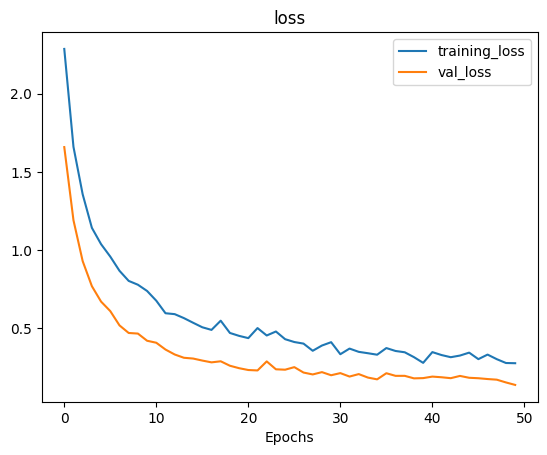

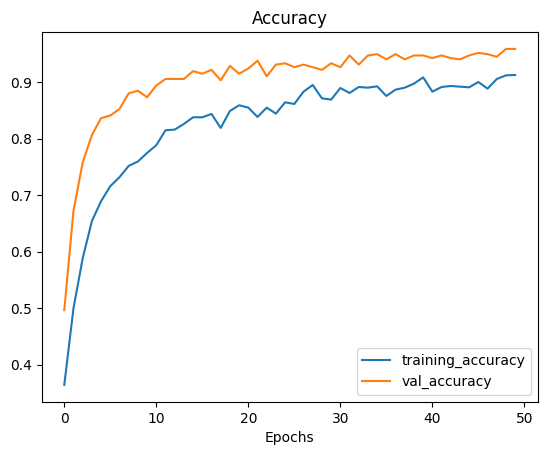

In [103]:
plot_loss_curves(H)

## We reached pretty good validation accuracy.

#### Let's check the rest like recall, precision, f1 etc

In [45]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
14/14 [==============================] - 2s 83ms/step
              precision    recall  f1-score   support

          A1       1.00      0.79      0.88        19
         A10       0.94      0.94      0.94        17
         A11       1.00      0.90      0.95        20
         A12       1.00      0.87      0.93        15
         A13       1.00      0.89      0.94         9
         A14       1.00      0.93      0.96        14
         A15       0.93      1.00      0.96        13
         A16       1.00      0.93      0.97        15
         A17       1.00      1.00      1.00        12
         A18       1.00      1.00      1.00        15
         A19       0.79      1.00      0.88        11
          A2       0.92      1.00      0.96        11
         A20       0.92      0.92      0.92        12
          A3       0.94      0.94      0.94        17
          A4       0.94      1.00      0.97        16
          A5       0.92      1.00      0.96        1

##  It seems that we have pretty high precision and recall so we have similar f1 score.

## I would also plot confusion matrix

In [105]:
y_true = lb.inverse_transform(testY.argmax(axis=1))
y_pred = lb.inverse_transform(predIdxs)

In [115]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_pred, labels = lb.classes_[:-1])

## I will remove no_aircraft colomn, we don't need it

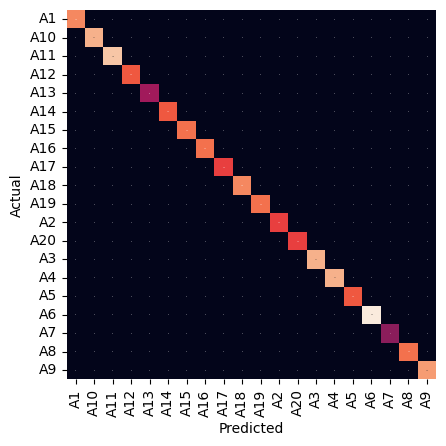

In [117]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, lb.classes_[:-1], lb.classes_[:-1])
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 1}, square=True, cbar=False, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## We can save this model and encoder

In [46]:
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")

print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] saving label encoder...


## Let's check the result

[INFO] loading model and label binarizer...
[INFO] running selective search...
[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...
7/7 [==============================] - 1s 49ms/step
[INFO] applying NMS...
show the output after *before* running NMS


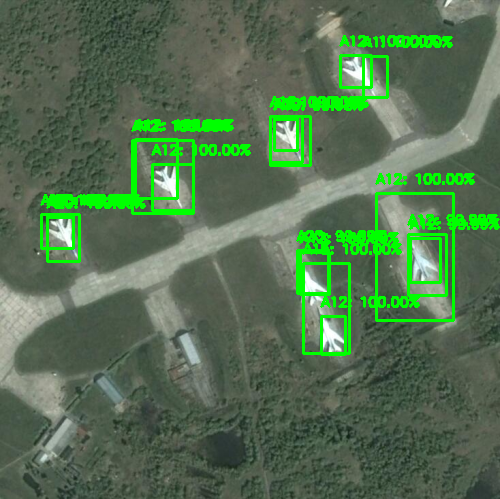

show the output image *after* running NMS


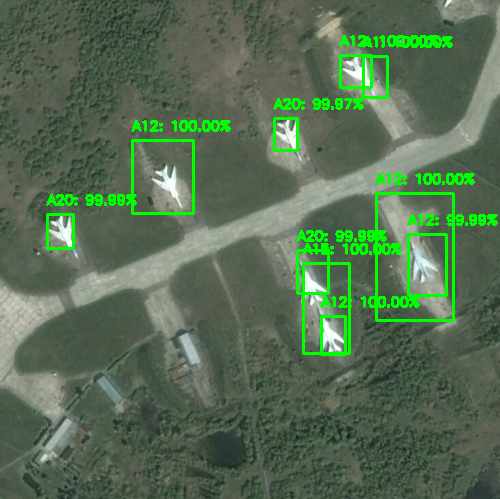

-1

In [81]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
from google.colab.patches import cv2_imshow


print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(ENCODER_PATH, "rb").read())

MIN_PROBA = 0.0005

image = cv2.imread('/content/military-aircraft-recognition-dataset/JPEGImages/200.jpg', cv2.IMREAD_COLOR)
image = imutils.resize(image, width=500)

print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()


proposals = []
boxes = []


for (x, y, w, h) in rects[:MAX_PROPOSALS_INFER]:
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, INPUT_SIZE,
		interpolation=cv2.INTER_CUBIC)

	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))

proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

print("[INFO] classifying proposals...")
proba = model.predict(proposals)

print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]

idxs = np.where(labels != "no_aircraft")
labels = labels[np.where(labels != "no_aircraft")]
boxes = boxes[idxs]
proba = proba[idxs][:, 1]


idxs = np.where(proba <= MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

clone = image.copy()


for (box, prob, label) in zip(boxes, proba, labels):
	(startX, startY, endX, endY) = box
	cv2.rectangle(clone, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "{}: {:.2f}%".format(label,(1-prob) * 100)
	cv2.putText(clone, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

print("show the output after *before* running NMS")
cv2_imshow(clone)


boxIdxs = non_max_suppression(boxes, proba)

for i in boxIdxs:
	(startX, startY, endX, endY) = boxes[i]
	cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	y = startY - 10 if startY - 10 > 10 else startY + 10
	text= "{}: {:.2f}%".format(labels[i],(1- proba[i]) * 100)
	cv2.putText(image, text, (startX, y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

print("show the output image *after* running NMS")
cv2_imshow(image)
cv2.waitKey(0)